# Dot Plot of Neuromodulator Receptor Expression in PL/IL/dACC (MERFISH)

This notebook uses **MERFISH spatial transcriptomics** data from the Allen Brain Cell
(ABC) Atlas to visualize neuromodulator receptor expression across cell types in the
**medial prefrontal cortex (mPFC)** of the mouse brain — specifically prelimbic (PL),
infralimbic (ILA), and dorsal anterior cingulate (ACAd/ACAv) areas.

### Key Advantage over 10x Data
MERFISH cells are registered to the **Allen CCF**, providing parcellation to individual
cortical areas (PL, ILA, ACAd, ACAv) rather than coarse dissection regions. This means:
- **All cell types are region-specific**, including interneurons and glia
- We can break down expression by individual cortical area

### MERFISH Gene Panel Limitation
Of the 28 receptor genes in the 10x analysis, **11 are in the MERFISH panel**:
- **Serotonin (5)**: Htr1b, Htr1d, Htr2a, Htr3a, Htr7
- **Norepinephrine (2)**: Adra1a, Adra1b
- **Dopamine (4)**: Drd1, Drd2, Drd3, Drd5

### Prerequisites
- Internet connection (for downloading data from AWS S3)
- Packages: `abc_atlas_access`, `anndata`, `scanpy`, `pandas`, `numpy`, `matplotlib`

In [1]:
import pandas as pd
import numpy as np
import re
import anndata
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache

## 1. Initialize the ABC Atlas Cache

In [2]:
download_base = Path('../../data/abc_atlas')
abc_cache = AbcProjectCache.from_s3_cache(download_base)
print(f"Current manifest: {abc_cache.current_manifest}")

Current manifest: releases/20251031/manifest.json


## 2. Load Cell Metadata with CCF Parcellation

In [3]:
ccf_meta = abc_cache.get_metadata_dataframe(
    directory='MERFISH-C57BL6J-638850-CCF',
    file_name='cell_metadata_with_parcellation_annotation',
    dtype={'cell_label': str}
)
ccf_meta.set_index('cell_label', inplace=True)
print(f"Total MERFISH cells with CCF: {len(ccf_meta):,}")

Total MERFISH cells with CCF: 3,739,961


## 3. Identify PL / IL / dACC Cells

Filter to cells within the prelimbic (PL), infralimbic (ILA), and anterior
cingulate (ACAd, ACAv) areas using CCF parcellation.

In [4]:
mpfc_structures = ['PL', 'ILA', 'ACAd', 'ACAv']
mpfc_cells = ccf_meta[ccf_meta['parcellation_structure'].isin(mpfc_structures)].copy()
print(f"mPFC cells: {len(mpfc_cells):,}")

print(f"\nBy structure:")
for s, count in mpfc_cells.groupby('parcellation_structure').size().items():
    print(f"  {s}: {count:,} cells")

print(f"\nAll subclasses:")
for sc_name, count in mpfc_cells.groupby('subclass', observed=True).size().sort_values(ascending=False).head(25).items():
    print(f"  {sc_name}: {count:,} cells")

mPFC cells: 78,516

By structure:
  ACAd: 25,482 cells
  ACAv: 27,707 cells
  ILA: 7,084 cells
  PL: 18,243 cells

All subclasses:
  030 L6 CT CTX Glut: 11,155 cells
  319 Astro-TE NN: 10,162 cells
  007 L2/3 IT CTX Glut: 9,040 cells
  006 L4/5 IT CTX Glut: 7,875 cells
  333 Endo NN: 5,655 cells
  004 L6 IT CTX Glut: 5,422 cells
  022 L5 ET CTX Glut: 5,124 cells
  005 L5 IT CTX Glut: 3,806 cells
  327 Oligo NN: 2,836 cells
  052 Pvalb Gaba: 2,595 cells
  032 L5 NP CTX Glut: 2,379 cells
  053 Sst Gaba: 2,072 cells
  029 L6b CTX Glut: 1,443 cells
  326 OPC NN: 1,353 cells
  334 Microglia NN: 1,169 cells
  003 L5/6 IT TPE-ENT Glut: 1,060 cells
  331 Peri NN: 912 cells
  046 Vip Gaba: 878 cells
  330 VLMC NN: 877 cells
  049 Lamp5 Gaba: 773 cells
  332 SMC NN: 483 cells
  047 Sncg Gaba: 367 cells
  020 L2/3 IT RSP Glut: 277 cells
  010 IT AON-TT-DP Glut: 171 cells
  002 IT EP-CLA Glut: 153 cells


In [5]:
# Cortical excitatory subclasses
excitatory_subclasses = [
    '007 L2/3 IT CTX Glut', '006 L4/5 IT CTX Glut', '005 L5 IT CTX Glut',
    '022 L5 ET CTX Glut', '032 L5 NP CTX Glut', '004 L6 IT CTX Glut',
    '030 L6 CT CTX Glut', '029 L6b CTX Glut',
]

# Interneuron subclasses
interneuron_subclasses = [
    '052 Pvalb Gaba', '051 Pvalb chandelier Gaba',
    '053 Sst Gaba', '056 Sst Chodl Gaba',
    '046 Vip Gaba', '049 Lamp5 Gaba',
    '050 Lamp5 Lhx6 Gaba', '047 Sncg Gaba',
]

# Glia
glia_subclasses = ['319 Astro-TE NN', '334 Microglia NN']

# Verify and filter (>= 40 cells)
mpfc_sc_counts = mpfc_cells.groupby('subclass', observed=True).size()
all_candidates = excitatory_subclasses + interneuron_subclasses + glia_subclasses
all_selected = [s for s in all_candidates if s in mpfc_sc_counts.index and mpfc_sc_counts[s] >= 40]

mpfc_selected = mpfc_cells[mpfc_cells['subclass'].isin(all_selected)].copy()

print(f"Selected mPFC cell types ({len(all_selected)} subclasses, {len(mpfc_selected):,} cells):")
for sc_name, count in mpfc_selected.groupby('subclass', observed=True).size().sort_values(ascending=False).items():
    if sc_name in excitatory_subclasses:
        tag = ' [excitatory]'
    elif sc_name in interneuron_subclasses:
        tag = ' [interneuron]'
    elif sc_name in glia_subclasses:
        tag = ' [glia]'
    else:
        tag = ''
    print(f"  {sc_name}: {count:,} cells{tag}")

Selected mPFC cell types (18 subclasses, 64,474 cells):
  030 L6 CT CTX Glut: 11,155 cells [excitatory]
  319 Astro-TE NN: 10,162 cells [glia]
  007 L2/3 IT CTX Glut: 9,040 cells [excitatory]
  006 L4/5 IT CTX Glut: 7,875 cells [excitatory]
  004 L6 IT CTX Glut: 5,422 cells [excitatory]
  022 L5 ET CTX Glut: 5,124 cells [excitatory]
  005 L5 IT CTX Glut: 3,806 cells [excitatory]
  052 Pvalb Gaba: 2,595 cells [interneuron]
  032 L5 NP CTX Glut: 2,379 cells [excitatory]
  053 Sst Gaba: 2,072 cells [interneuron]
  029 L6b CTX Glut: 1,443 cells [excitatory]
  334 Microglia NN: 1,169 cells [glia]
  046 Vip Gaba: 878 cells [interneuron]
  049 Lamp5 Gaba: 773 cells [interneuron]
  047 Sncg Gaba: 367 cells [interneuron]
  051 Pvalb chandelier Gaba: 91 cells [interneuron]
  056 Sst Chodl Gaba: 76 cells [interneuron]
  050 Lamp5 Lhx6 Gaba: 47 cells [interneuron]


## 4. Define Receptor Gene Lists

11 of 28 receptor genes are in the MERFISH 550-gene panel.

In [6]:
gene = abc_cache.get_metadata_dataframe(directory='MERFISH-C57BL6J-638850', file_name='gene')
gene.set_index('gene_identifier', inplace=True)

serotonin_receptors = ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7']
norepinephrine_receptors = ['Adra1a', 'Adra1b']
dopamine_receptors = ['Drd1', 'Drd2', 'Drd3', 'Drd5']
all_receptors = serotonin_receptors + norepinephrine_receptors + dopamine_receptors

available_genes = gene[gene['gene_symbol'].isin(all_receptors)]
receptor_genes = [g for g in all_receptors if g in set(available_genes['gene_symbol'])]
gene_ensembl_ids = available_genes.index.tolist()

print(f"MERFISH panel: {len(gene)} genes")
print(f"Receptor genes available: {len(receptor_genes)} — {receptor_genes}")

all_28 = [
    'Htr1a','Htr1b','Htr1d','Htr1f','Htr2a','Htr2b','Htr2c','Htr3a','Htr3b','Htr4','Htr5a','Htr5b','Htr6','Htr7',
    'Adra1a','Adra1b','Adra1d','Adra2a','Adra2b','Adra2c','Adrb1','Adrb2','Adrb3',
    'Drd1','Drd2','Drd3','Drd4','Drd5'
]
missing = [g for g in all_28 if g not in receptor_genes]
print(f"Not in MERFISH panel ({len(missing)}): {missing}")

MERFISH panel: 550 genes
Receptor genes available: 11 — ['Htr1b', 'Htr1d', 'Htr2a', 'Htr3a', 'Htr7', 'Adra1a', 'Adra1b', 'Drd1', 'Drd2', 'Drd3', 'Drd5']
Not in MERFISH panel (17): ['Htr1a', 'Htr1f', 'Htr2b', 'Htr2c', 'Htr3b', 'Htr4', 'Htr5a', 'Htr5b', 'Htr6', 'Adra1d', 'Adra2a', 'Adra2b', 'Adra2c', 'Adrb1', 'Adrb2', 'Adrb3', 'Drd4']


## 5. Load Expression Data

In [7]:
import os

file_path = abc_cache.get_file_path(
    directory='MERFISH-C57BL6J-638850',
    file_name='C57BL6J-638850/log2'
)
print(f"MERFISH expression: {os.path.getsize(file_path) / 1e9:.1f} GB")

adata = anndata.read_h5ad(file_path, backed='r')
print(f"Matrix: {adata.shape[0]:,} cells x {adata.shape[1]} genes")

gene_mask = adata.var.index.isin(gene_ensembl_ids)
cell_mask = adata.obs.index.isin(mpfc_selected.index)
cell_idx = np.where(cell_mask)[0]
gene_idx = np.where(gene_mask)[0]

print(f"mPFC cells found: {len(cell_idx):,}")
print(f"Receptor genes found: {len(gene_idx)}")

subset = adata[cell_idx, gene_idx].to_memory()
gene_filtered = adata.var[gene_mask]
expression_data = subset.to_df()
expression_data.columns = gene_filtered['gene_symbol'].values
expression_data = expression_data[receptor_genes]

adata.file.close()
del adata
print(f"\nExtracted: {expression_data.shape[0]:,} cells x {expression_data.shape[1]} genes")

MERFISH expression: 7.6 GB


Matrix: 4,334,174 cells x 550 genes
mPFC cells found: 64,474
Receptor genes found: 11



Extracted: 64,474 cells x 11 genes


## 6. Build AnnData Object

In [8]:
adata_mpfc = anndata.AnnData(
    X=expression_data.values,
    obs=mpfc_selected.loc[expression_data.index,
         ['subclass', 'supertype', 'class', 'neurotransmitter',
          'parcellation_structure', 'parcellation_substructure']].copy(),
    var=pd.DataFrame(index=receptor_genes)
)

adata_mpfc.obs['subclass_short'] = adata_mpfc.obs['subclass'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_mpfc.obs['supertype_short'] = adata_mpfc.obs['supertype'].apply(
    lambda x: re.sub(r'^\d+\s+', '', x)
)
adata_mpfc.obs['subclass_short'] = pd.Categorical(adata_mpfc.obs['subclass_short'])
adata_mpfc.obs['supertype_short'] = pd.Categorical(adata_mpfc.obs['supertype_short'])

n_subclasses = adata_mpfc.obs['subclass_short'].cat.categories.size
n_supertypes = adata_mpfc.obs['supertype_short'].cat.categories.size
print(adata_mpfc)
print(f"\n{n_subclasses} subclasses, {n_supertypes} supertypes")

AnnData object with n_obs × n_vars = 64474 × 11
    obs: 'subclass', 'supertype', 'class', 'neurotransmitter', 'parcellation_structure', 'parcellation_substructure', 'subclass_short', 'supertype_short'

18 subclasses, 97 supertypes


## 7. Dot Plot: mPFC Cell Types (Subclass)

All cell types are spatially confirmed within PL/ILA/ACAd/ACAv via CCF.

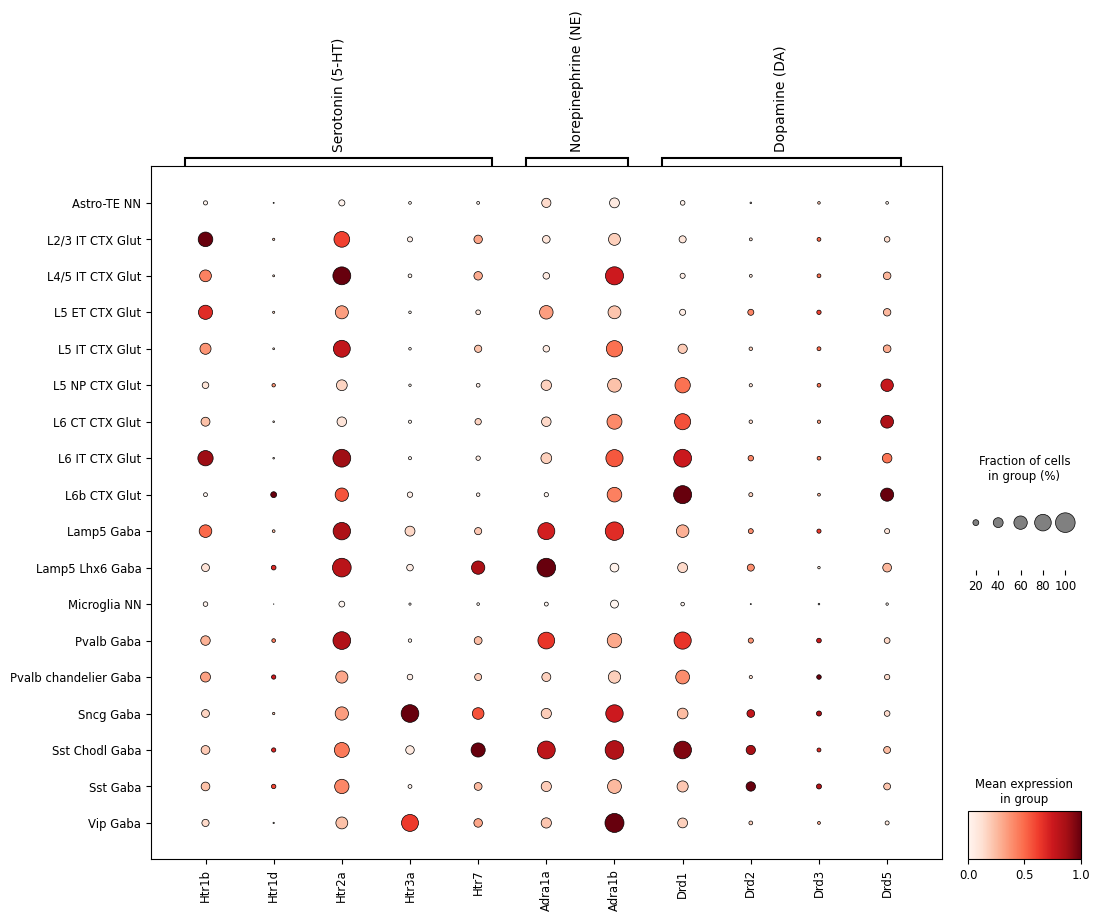

Saved: dotplot_mPFC_MERFISH_receptors_by_subclass.png


In [9]:
receptor_groups = {
    'Serotonin (5-HT)': [g for g in serotonin_receptors if g in receptor_genes],
    'Norepinephrine (NE)': [g for g in norepinephrine_receptors if g in receptor_genes],
    'Dopamine (DA)': [g for g in dopamine_receptors if g in receptor_genes],
}

dp = sc.pl.dotplot(
    adata_mpfc,
    var_names=receptor_groups,
    groupby='subclass_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(6, n_subclasses * 0.5)),
    show=False,
    return_fig=True
)
dp.style(dot_edge_color='black', dot_edge_lw=0.5)
dp.savefig('dotplot_mPFC_MERFISH_receptors_by_subclass.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_mPFC_MERFISH_receptors_by_subclass.png")

## 8. Finer View: Grouped by Supertype

Supertypes with >= 40 cells: 73


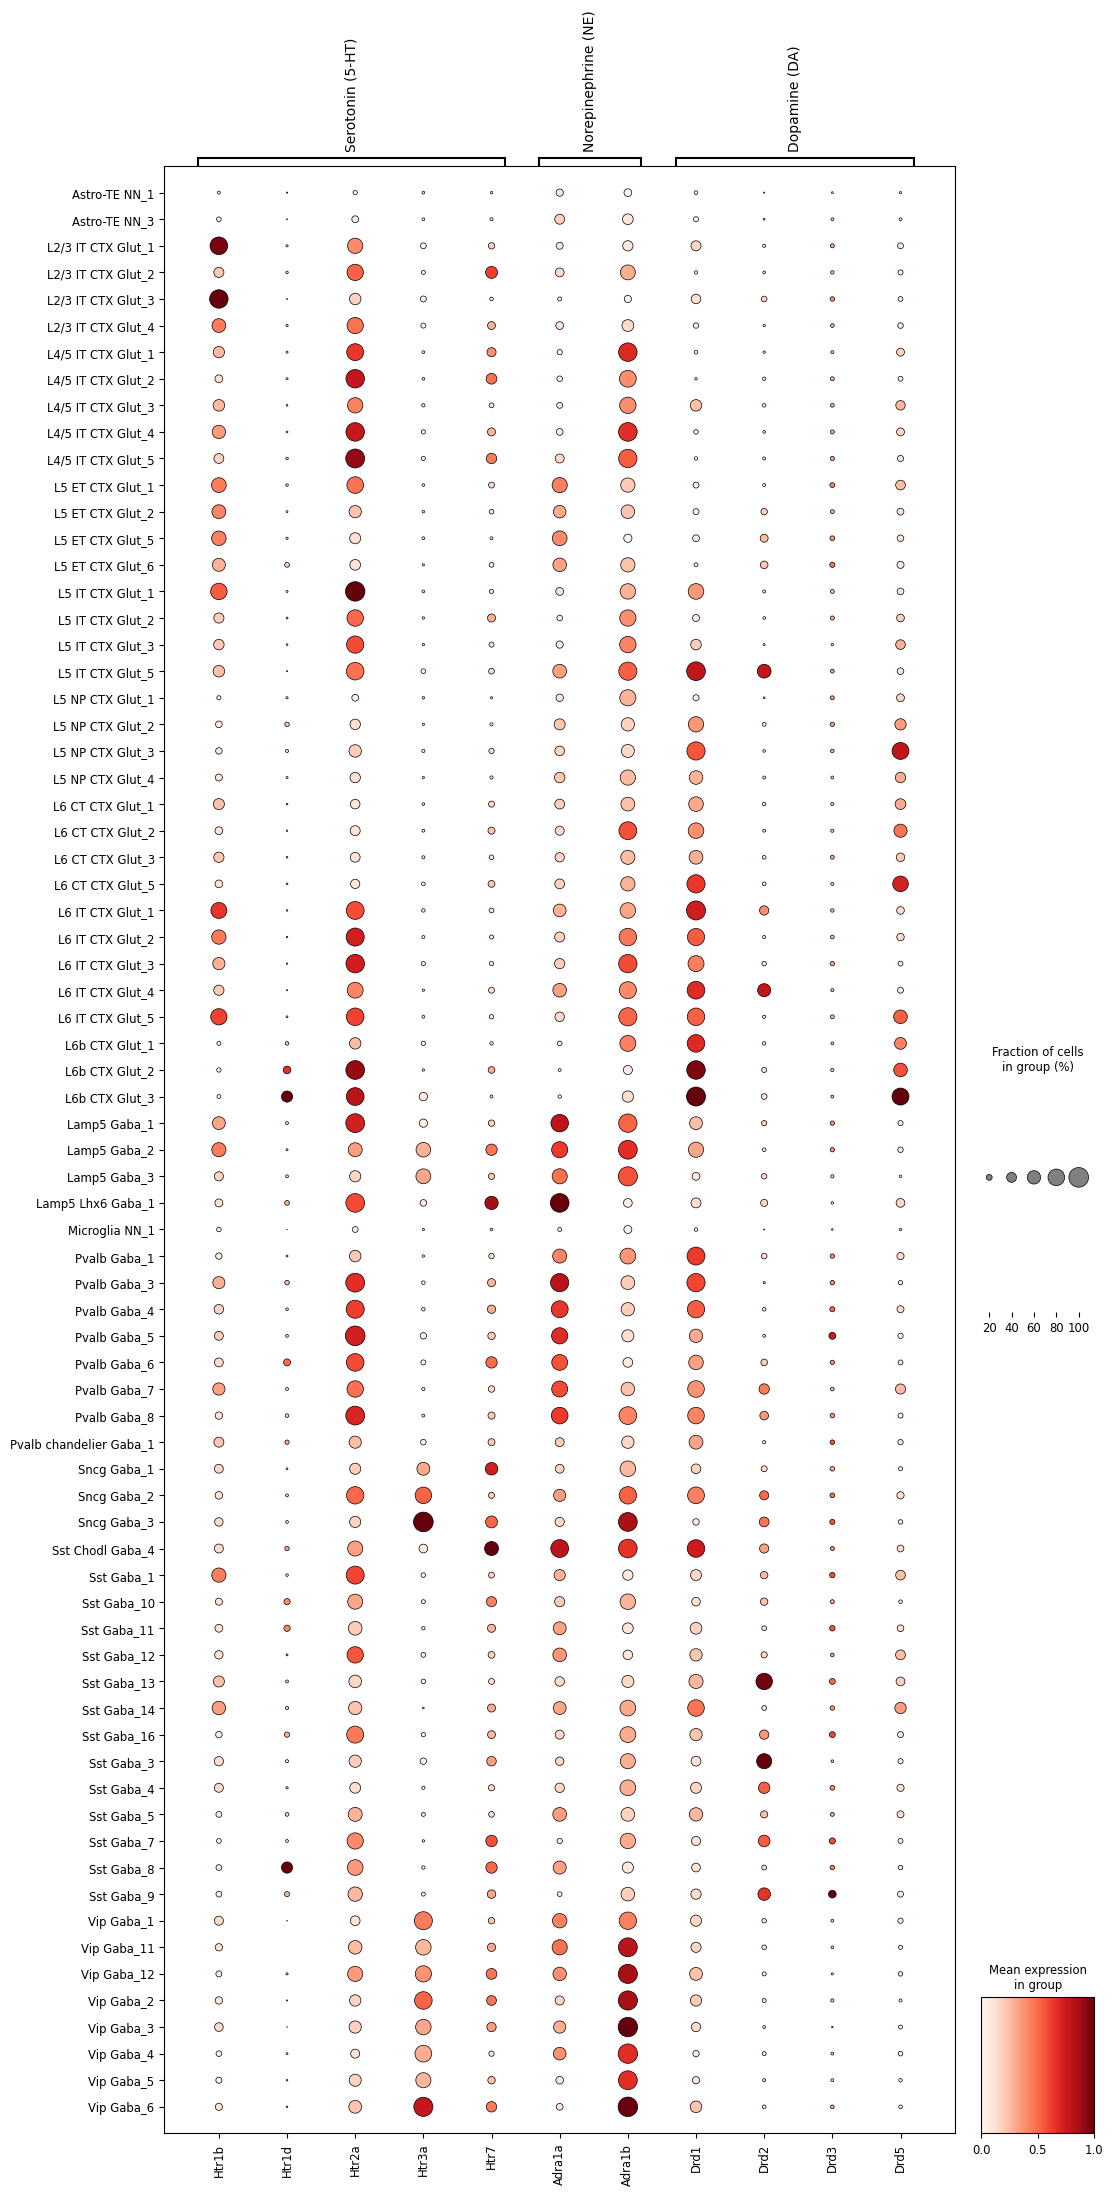

Saved: dotplot_mPFC_MERFISH_receptors_by_supertype.png


In [10]:
min_cells = 40
supertype_counts = adata_mpfc.obs.groupby('supertype', observed=True).size()
valid_supertypes = supertype_counts[supertype_counts >= min_cells].index.tolist()

adata_st = adata_mpfc[adata_mpfc.obs['supertype'].isin(valid_supertypes)].copy()
adata_st.obs['supertype_short'] = pd.Categorical(adata_st.obs['supertype_short'])

n_st = len(valid_supertypes)
print(f"Supertypes with >= {min_cells} cells: {n_st}")

dp2 = sc.pl.dotplot(
    adata_st,
    var_names=receptor_groups,
    groupby='supertype_short',
    standard_scale='var',
    cmap='Reds',
    figsize=(12, max(8, n_st * 0.35)),
    show=False,
    return_fig=True
)
dp2.style(dot_edge_color='black', dot_edge_lw=0.5)
dp2.savefig('dotplot_mPFC_MERFISH_receptors_by_supertype.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_mPFC_MERFISH_receptors_by_supertype.png")

## 9. Breakdown by Cortical Area (PL / ILA / ACAd / ACAv)

Split each cell type by cortical area to reveal any regional differences
in receptor expression across prelimbic, infralimbic, and anterior cingulate.

Cell type x region groups (>= 30 cells): 60
  L2/3 IT CTX Glut (PL): 1,668
  L2/3 IT CTX Glut (ILA): 873
  L2/3 IT CTX Glut (ACAd): 3,002
  L2/3 IT CTX Glut (ACAv): 3,497
  L4/5 IT CTX Glut (PL): 2,260
  L4/5 IT CTX Glut (ILA): 483
  L4/5 IT CTX Glut (ACAd): 2,568
  L4/5 IT CTX Glut (ACAv): 2,564
  L5 ET CTX Glut (PL): 948
  L5 ET CTX Glut (ILA): 523
  L5 ET CTX Glut (ACAd): 1,376
  L5 ET CTX Glut (ACAv): 2,277
  L5 IT CTX Glut (PL): 179
  L5 IT CTX Glut (ILA): 109
  L5 IT CTX Glut (ACAd): 1,196
  L5 IT CTX Glut (ACAv): 2,322
  L5 NP CTX Glut (PL): 557
  L5 NP CTX Glut (ILA): 206
  L5 NP CTX Glut (ACAd): 741
  L5 NP CTX Glut (ACAv): 875
  L6 CT CTX Glut (PL): 2,921
  L6 CT CTX Glut (ILA): 1,130
  L6 CT CTX Glut (ACAd): 3,440
  L6 CT CTX Glut (ACAv): 3,664
  L6 IT CTX Glut (PL): 1,564
  L6 IT CTX Glut (ILA): 251
  L6 IT CTX Glut (ACAd): 1,966
  L6 IT CTX Glut (ACAv): 1,641
  L6b CTX Glut (PL): 311
  L6b CTX Glut (ILA): 107
  L6b CTX Glut (ACAd): 503
  L6b CTX Glut (ACAv): 522
  Lamp5 Ga

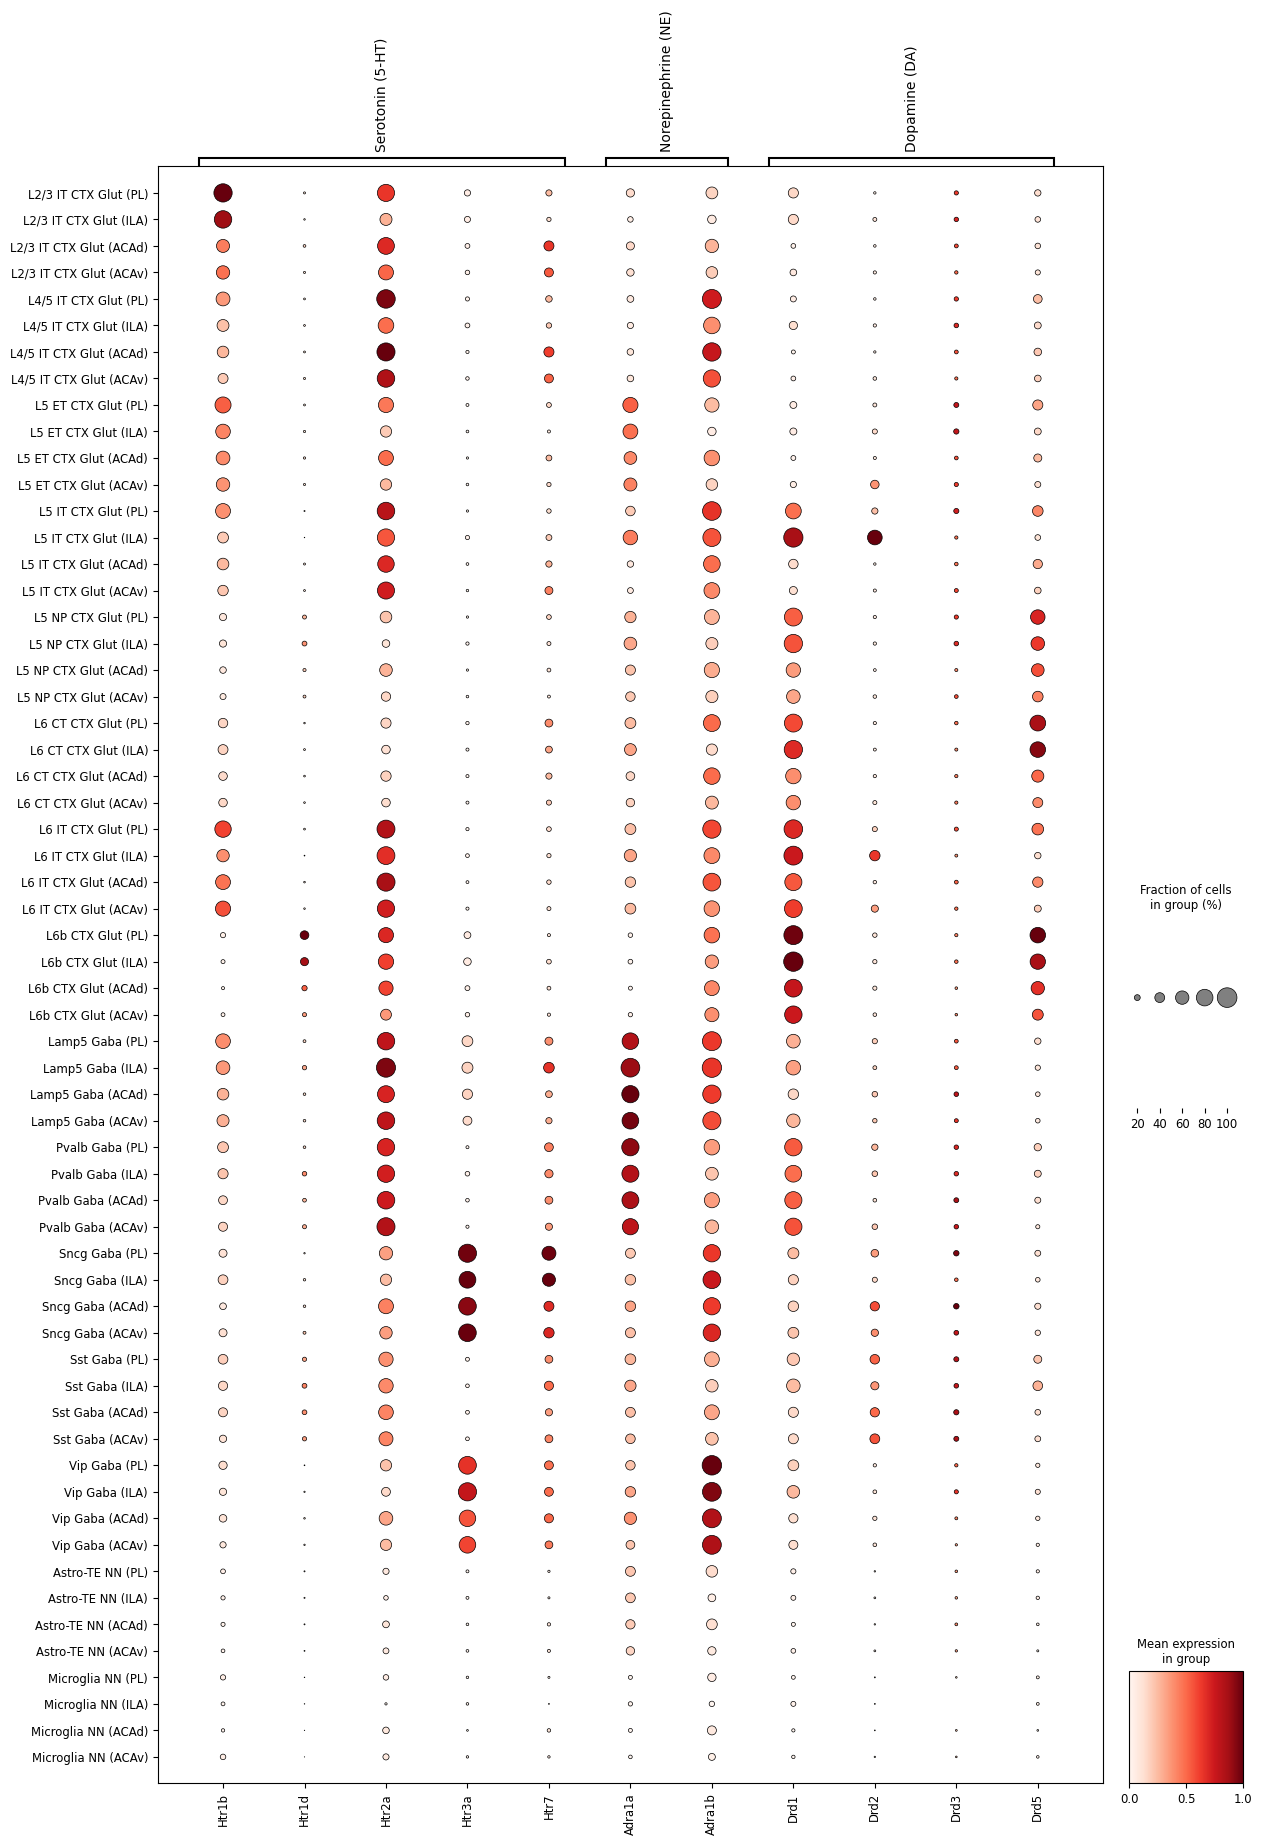

Saved: dotplot_mPFC_MERFISH_receptors_by_area.png


In [11]:
# Combined label: subclass + cortical area
adata_mpfc.obs['cell_type_region'] = (
    adata_mpfc.obs['subclass_short'].astype(str) + ' (' +
    adata_mpfc.obs['parcellation_structure'].astype(str) + ')'
)

# Filter to groups with >= 30 cells
group_counts = adata_mpfc.obs.groupby('cell_type_region', observed=True).size()
valid_groups = group_counts[group_counts >= 30].index.tolist()
adata_region = adata_mpfc[adata_mpfc.obs['cell_type_region'].isin(valid_groups)].copy()

# Sort: excitatory, interneurons, glia; within each by PL/ILA/ACAd/ACAv
def sort_key(name):
    parts = name.rsplit(' (', 1)
    sc = parts[0]
    region = parts[1].rstrip(')') if len(parts) > 1 else ''
    if any(kw in sc for kw in ['Glut', 'IT CTX', 'ET CTX', 'NP CTX', 'CT CTX', 'L6b']):
        cat = 0
    elif 'NN' in sc:
        cat = 2
    else:
        cat = 1
    region_order = {'PL': 0, 'ILA': 1, 'ACAd': 2, 'ACAv': 3}
    return (cat, sc, region_order.get(region, 9))

sorted_groups = sorted(valid_groups, key=sort_key)
adata_region.obs['cell_type_region'] = pd.Categorical(
    adata_region.obs['cell_type_region'], categories=sorted_groups, ordered=True
)

n_groups = len(sorted_groups)
print(f"Cell type x region groups (>= 30 cells): {n_groups}")
for g in sorted_groups:
    print(f"  {g}: {group_counts[g]:,}")

dp3 = sc.pl.dotplot(
    adata_region,
    var_names=receptor_groups,
    groupby='cell_type_region',
    standard_scale='var',
    cmap='Reds',
    figsize=(14, max(10, n_groups * 0.35)),
    show=False,
    return_fig=True
)
dp3.style(dot_edge_color='black', dot_edge_lw=0.5)
dp3.savefig('dotplot_mPFC_MERFISH_receptors_by_area.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved: dotplot_mPFC_MERFISH_receptors_by_area.png")

## 10. Summary Statistics

In [12]:
expr_df = pd.DataFrame(
    adata_mpfc.X,
    index=adata_mpfc.obs.index,
    columns=adata_mpfc.var.index
)
expr_df['subclass'] = adata_mpfc.obs['subclass_short'].values

mean_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].mean()
frac_expr = expr_df.groupby('subclass', observed=True)[receptor_genes].apply(
    lambda x: (x > 0).mean()
)

print("=" * 70)
print("Mean Expression (log2) by mPFC Subclass — MERFISH")
print("=" * 70)
display(mean_expr.round(2))

print("\n" + "=" * 70)
print("Fraction of Expressing Cells by mPFC Subclass — MERFISH")
print("=" * 70)
display(frac_expr.round(3))

Mean Expression (log2) by mPFC Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
Astro-TE NN,0.13,0.02,0.23,0.07,0.07,0.40,0.47,0.15,0.04,0.06,0.07
L2/3 IT CTX Glut,1.39,0.05,1.47,0.18,0.37,0.30,0.78,0.33,0.08,0.10,0.18
L4/5 IT CTX Glut,0.66,0.04,2.29,0.11,0.36,0.23,2.22,0.20,0.07,0.10,0.30
L5 ET CTX Glut,0.98,0.05,0.91,0.06,0.14,0.79,0.86,0.21,0.24,0.12,0.29
L5 IT CTX Glut,0.58,0.03,1.84,0.06,0.28,0.23,1.53,0.58,0.12,0.10,0.33
L5 NP CTX Glut,0.24,0.09,0.55,0.06,0.10,0.47,0.89,1.24,0.08,0.10,0.76
L6 CT CTX Glut,0.41,0.03,0.42,0.09,0.23,0.42,1.34,1.46,0.09,0.08,0.83
L6 IT CTX Glut,1.24,0.03,2.05,0.08,0.12,0.48,1.71,1.90,0.24,0.09,0.48
L6b CTX Glut,0.11,0.23,1.38,0.19,0.10,0.13,1.42,2.50,0.12,0.07,0.97



Fraction of Expressing Cells by mPFC Subclass — MERFISH


,Htr1b,Htr1d,Htr2a,Htr3a,Htr7,Adra1a,Adra1b,Drd1,Drd2,Drd3,Drd5
subclass,,,,,,,,,,,
Astro-TE NN,0.127,0.021,0.212,0.073,0.078,0.365,0.400,0.146,0.036,0.068,0.071
L2/3 IT CTX Glut,0.675,0.056,0.744,0.167,0.325,0.285,0.517,0.259,0.079,0.113,0.186
L4/5 IT CTX Glut,0.507,0.046,0.883,0.108,0.326,0.235,0.896,0.167,0.077,0.114,0.282
L5 ET CTX Glut,0.646,0.053,0.580,0.067,0.150,0.609,0.571,0.210,0.208,0.134,0.276
L5 IT CTX Glut,0.467,0.043,0.821,0.067,0.265,0.230,0.780,0.368,0.101,0.117,0.286
L5 NP CTX Glut,0.233,0.098,0.451,0.063,0.111,0.429,0.625,0.719,0.090,0.109,0.545
L6 CT CTX Glut,0.351,0.038,0.384,0.087,0.223,0.382,0.696,0.766,0.100,0.093,0.566
L6 IT CTX Glut,0.717,0.037,0.878,0.086,0.136,0.449,0.837,0.879,0.183,0.109,0.384
L6b CTX Glut,0.117,0.202,0.598,0.179,0.102,0.132,0.676,0.893,0.122,0.076,0.586
